In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f"Using device: {device}")

Using device: cuda


In [2]:
main_path = 'datasets/real-vs-fake'
train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

print("Train_dir Subfolders:", os.listdir(train_dir))
print("Valid_dir Subfolders:", os.listdir(valid_dir))
print("Test_dir Subfolders:", os.listdir(test_dir))

Train_dir Subfolders: ['fake', 'real']
Valid_dir Subfolders: ['fake', 'real']
Test_dir Subfolders: ['fake', 'real']


In [3]:
images_df = {"folder": [], "image_path": [], "label": []}

for folder in os.listdir(main_path):
    for label in os.listdir(os.path.join(main_path, folder)):
        for img in glob.glob(os.path.join(main_path, folder, label, "*.jpg")):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

images_df = pd.DataFrame(images_df)
display(images_df.head())

# Analyze distribution
print("\nReal images per folder:")
print(images_df[images_df['label'] == "real"].groupby('folder').size())
print("\nFake images per folder:")
print(images_df[images_df['label'] == "fake"].groupby('folder').size())

,folder,image_path,label
0,test,datasets/real-vs-fake/test/fake/3DY7NUAXMF.jpg,fake
1,test,datasets/real-vs-fake/test/fake/RB5QT0T79J.jpg,fake
2,test,datasets/real-vs-fake/test/fake/GI80PPDRFW.jpg,fake
3,test,datasets/real-vs-fake/test/fake/SX2ND427JI.jpg,fake
4,test,datasets/real-vs-fake/test/fake/P4QL3V9MTB.jpg,fake



Real images per folder:
folder
test     10000
train    50000
valid    10000
dtype: int64

Fake images per folder:
folder
test     10000
train    50000
valid    10000
dtype: int64


In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = torchvision.datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 100000
Validation samples: 20000
Test samples: 20000


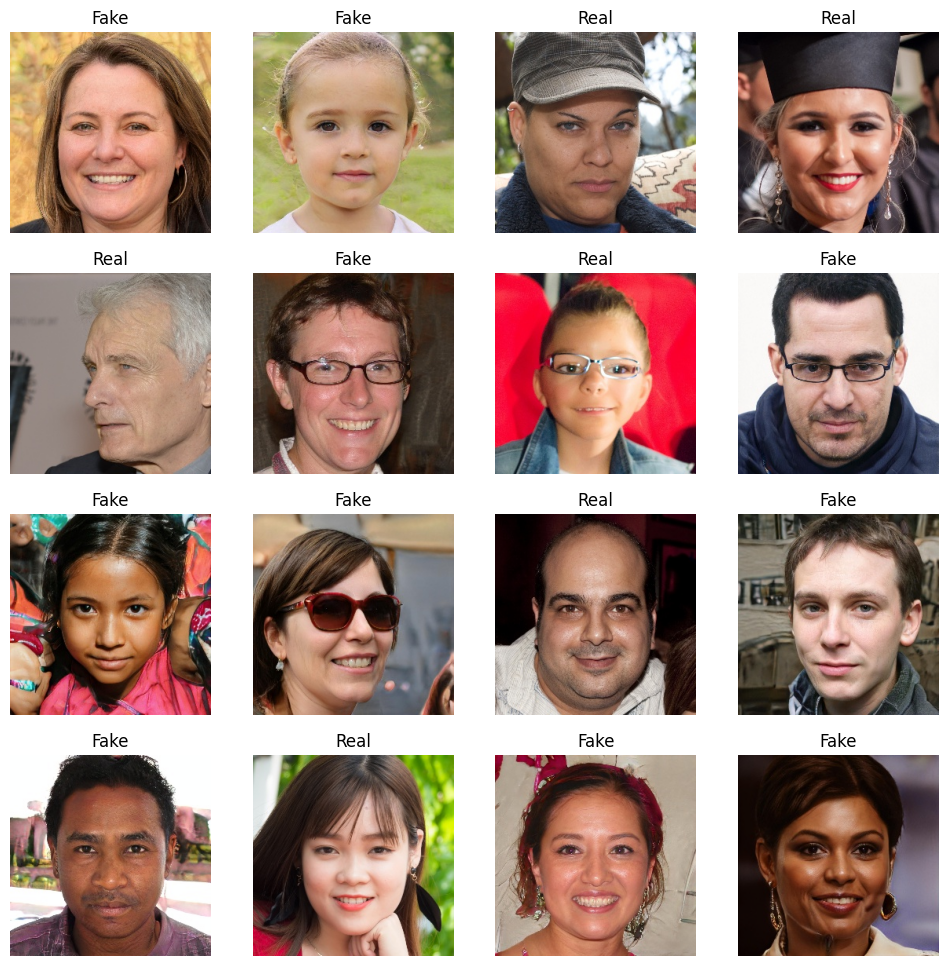

In [6]:
def plot_images(images, labels, num_images=16):
    images = images.numpy()
    labels = labels.numpy()
    fig = plt.figure(figsize=(12, 12))
    for i in range(min(num_images, len(images))):
        plt.subplot(4, 4, i+1)
        img = np.transpose(images[i], (1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title("Real" if labels[i] == 1 else "Fake")
        plt.axis('off')
    plt.show()

# Visualize some training images
images, labels = next(iter(train_loader))
plot_images(images, labels)

In [7]:
class FaceClassifier(nn.Module):
    def __init__(self):
        super(FaceClassifier, self).__init__()
        # Load pretrained DenseNet121
        self.backbone = models.densenet121(pretrained=True)
        
        # Get the number of features from the last layer
        num_features = self.backbone.classifier.in_features
        
        # Replace the classifier
        self.backbone.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.backbone(x)

In [8]:
# Initialize model
model = FaceClassifier().to(device)
print(model)
# Model parameters count
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

/home/rahi/miniconda3/envs/vit/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rahi/miniconda3/envs/vit/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaceClassifier(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                               mode='min', 
                                               factor=0.2, 
                                               patience=3)

In [10]:
def train_model(model, train_loader, valid_loader, num_epochs=10):
    history = {
        'train_loss': [], 'train_acc': [], 'train_prec': [], 'train_rec': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_prec': [], 'val_rec': [], 'val_f1': []
    }
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_loop:
            images, labels = images.to(device), labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs > 0.5).float().cpu().numpy()
            train_preds.extend(predicted)
            train_labels.extend(labels.cpu().numpy())
            
            train_loop.set_postfix({'loss': loss.item()})
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        valid_loop = tqdm(valid_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]')
        with torch.no_grad():
            for images, labels in valid_loop:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predicted = (outputs > 0.5).float().cpu().numpy()
                val_preds.extend(predicted)
                val_labels.extend(labels.cpu().numpy())
                
                valid_loop.set_postfix({'loss': loss.item()})
        
        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        train_prec = precision_score(train_labels, train_preds)
        train_rec = recall_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds)
        
        val_loss = val_loss / len(valid_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_prec = precision_score(val_labels, val_preds)
        val_rec = recall_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_prec'].append(train_prec)
        history['train_rec'].append(train_rec)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_prec'].append(val_prec)
        history['val_rec'].append(val_rec)
        history['val_f1'].append(val_f1)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}')
        print(f'Valid - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}')
    
    return history

In [11]:
history = train_model(model, train_loader, valid_loader, num_epochs=3)

Epoch 1/3 [Valid]: 100%|██████████| 313/313 [00:30<00:00, 10.38it/s, loss=0.0237] 



Epoch 1/3:
Train - Loss: 0.1194, Acc: 0.9520, Prec: 0.9515, Rec: 0.9525, F1: 0.9520
Valid - Loss: 0.0375, Acc: 0.9879, Prec: 0.9907, Rec: 0.9851, F1: 0.9879


Epoch 2/3 [Valid]: 100%|██████████| 313/313 [00:31<00:00,  9.94it/s, loss=0.00351]



Epoch 2/3:
Train - Loss: 0.0503, Acc: 0.9815, Prec: 0.9809, Rec: 0.9821, F1: 0.9815
Valid - Loss: 0.1102, Acc: 0.9558, Prec: 0.9249, Rec: 0.9922, F1: 0.9574


Epoch 3/3 [Valid]: 100%|██████████| 313/313 [00:31<00:00,  9.92it/s, loss=0.0288]  



Epoch 3/3:
Train - Loss: 0.0404, Acc: 0.9851, Prec: 0.9847, Rec: 0.9855, F1: 0.9851
Valid - Loss: 0.0526, Acc: 0.9798, Prec: 0.9972, Rec: 0.9622, F1: 0.9794


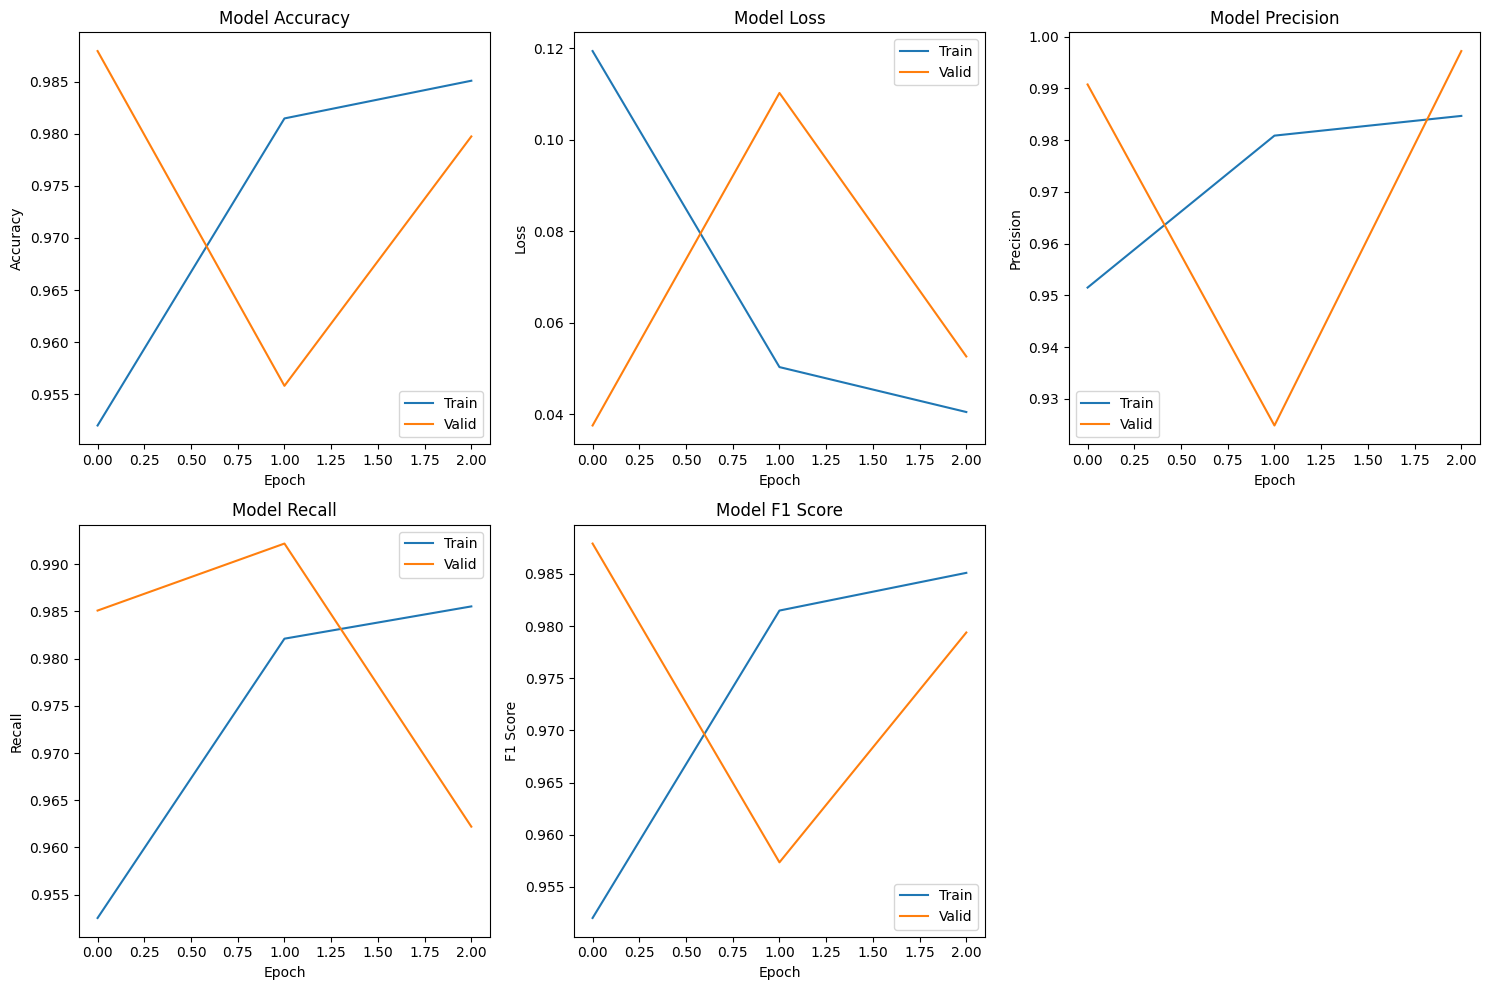

In [12]:
plt.figure(figsize=(15, 10))

metrics = ['acc', 'loss', 'prec', 'rec', 'f1']
titles = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1 Score']

for i, (metric, title) in enumerate(zip(metrics, titles), 1):
    plt.subplot(2, 3, i)
    plt.plot(history[f'train_{metric}'], label='Train')
    plt.plot(history[f'val_{metric}'], label='Valid')
    plt.title(f'Model {title}')
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend()

plt.tight_layout()
plt.show()

In [13]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    test_preds = []
    test_labels = []
    
    test_loop = tqdm(test_loader, desc='Testing')
    with torch.no_grad():
        for images, labels in test_loop:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            predicted = (outputs > 0.5).float().cpu().numpy()
            test_preds.extend(predicted)
            test_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_acc = accuracy_score(test_labels, test_preds)
    test_prec = precision_score(test_labels, test_preds)
    test_rec = recall_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds)
    test_cm = confusion_matrix(test_labels, test_preds)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Precision: {test_prec:.4f}")
    print(f"Test Recall: {test_rec:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Confusion Matrix:\n{test_cm}")
    
    return test_loss, test_acc, test_prec, test_rec, test_f1, test_cm

In [14]:
test_results = evaluate_model(model, test_loader)

Testing: 100%|██████████| 313/313 [00:31<00:00, 10.02it/s]

Test Loss: 0.0513
Test Accuracy: 0.9810
Test Precision: 0.9978
Test Recall: 0.9642
Test F1 Score: 0.9807
Confusion Matrix:
[[9979   21]
 [ 358 9642]]


## Save the Model

In [15]:
# torch.save(model, 'models/real_vs_fake.pth')
save_path = 'models/real_vs_fake_face_cnn_state.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to models/real_vs_fake_face_cnn_state.pth
